In [1]:
# Importing necessary libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Additional libraries
from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [3]:
# Hyperparameters
batch_size = 256
img_size = 28  # Original image size is 28x28
channels = 1  # Grayscale image
latent_dim = 2
num_epochs = 500  # Training epochs

# Data transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Dataset loading
dataset = datasets.MNIST(
    root="./data",  # Data storage directory
    train=True,
    transform=transform,
    download=True,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.85MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.11MB/s]


In [4]:
# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Training samples: 48000, Validation samples: 12000


In [5]:
# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.flatten_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*reconstruction_loss + KL loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)

    return total_loss, reconstruction_loss, torch.mean(kl_loss)

In [7]:
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file and write initial details
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
          f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

# Log training completion
with open(log_file, "a") as f:
    f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Training log saved to {log_file}")

Epoch 1/500 Loss per sample: 266.4385 Recon Loss: 47.5382 KL Loss: 13.1862


Epoch 2/500 Loss per sample: 167.9324 Recon Loss: 40.0420 KL Loss: 11.6312


Epoch 3/500 Loss per sample: 155.6009 Recon Loss: 36.9568 KL Loss: 12.3150


Epoch 4/500 Loss per sample: 148.6374 Recon Loss: 33.6892 KL Loss: 13.9839


Epoch 5/500 Loss per sample: 144.1574 Recon Loss: 38.2472 KL Loss: 12.6990


Epoch 6/500 Loss per sample: 141.1911 Recon Loss: 36.7989 KL Loss: 14.4238


Epoch 7/500 Loss per sample: 139.0480 Recon Loss: 36.0174 KL Loss: 13.0670


Epoch 8/500 Loss per sample: 137.2035 Recon Loss: 34.8595 KL Loss: 14.1626


Epoch 9/500 Loss per sample: 135.4995 Recon Loss: 35.9480 KL Loss: 14.3055


Epoch 10/500 Loss per sample: 134.6403 Recon Loss: 36.7695 KL Loss: 13.8255


Epoch 11/500 Loss per sample: 133.2869 Recon Loss: 34.3179 KL Loss: 15.1157


Epoch 12/500 Loss per sample: 132.3813 Recon Loss: 35.1887 KL Loss: 15.2409


Epoch 13/500 Loss per sample: 131.4889 Recon Loss: 33.3237 KL Loss: 15.9515


Epoch 14/500 Loss per sample: 130.9295 Recon Loss: 31.9341 KL Loss: 16.1412


Epoch 15/500 Loss per sample: 130.5259 Recon Loss: 34.1040 KL Loss: 17.0169


Epoch 16/500 Loss per sample: 129.8255 Recon Loss: 32.0459 KL Loss: 16.7174


Epoch 17/500 Loss per sample: 129.4125 Recon Loss: 34.5548 KL Loss: 15.5832


Epoch 18/500 Loss per sample: 129.1077 Recon Loss: 34.9091 KL Loss: 14.2872


Epoch 19/500 Loss per sample: 128.5308 Recon Loss: 32.9721 KL Loss: 16.6262


Epoch 20/500 Loss per sample: 128.2751 Recon Loss: 34.3263 KL Loss: 15.6243


Epoch 21/500 Loss per sample: 127.8210 Recon Loss: 33.0030 KL Loss: 15.6219


Epoch 22/500 Loss per sample: 127.4662 Recon Loss: 35.4145 KL Loss: 14.9112


Epoch 23/500 Loss per sample: 127.1297 Recon Loss: 33.2260 KL Loss: 15.9664


Epoch 24/500 Loss per sample: 127.0871 Recon Loss: 30.5674 KL Loss: 15.4489


Epoch 25/500 Loss per sample: 126.4826 Recon Loss: 31.0426 KL Loss: 16.1524


Epoch 26/500 Loss per sample: 126.2053 Recon Loss: 31.9028 KL Loss: 16.0775


Epoch 27/500 Loss per sample: 126.0225 Recon Loss: 32.7173 KL Loss: 15.8201


Epoch 28/500 Loss per sample: 125.7113 Recon Loss: 31.1489 KL Loss: 15.6427


Epoch 29/500 Loss per sample: 125.6367 Recon Loss: 32.9504 KL Loss: 15.7666


Epoch 30/500 Loss per sample: 125.4897 Recon Loss: 33.9341 KL Loss: 15.5724


Epoch 31/500 Loss per sample: 125.1587 Recon Loss: 31.8771 KL Loss: 15.4376


Epoch 32/500 Loss per sample: 124.8561 Recon Loss: 30.5615 KL Loss: 16.0498


Epoch 33/500 Loss per sample: 124.5242 Recon Loss: 33.3955 KL Loss: 16.8899


Epoch 34/500 Loss per sample: 124.6880 Recon Loss: 31.3058 KL Loss: 16.4448


Epoch 35/500 Loss per sample: 124.3299 Recon Loss: 32.8506 KL Loss: 17.1261


Epoch 36/500 Loss per sample: 124.0670 Recon Loss: 30.7278 KL Loss: 16.5213


Epoch 37/500 Loss per sample: 123.8369 Recon Loss: 32.2962 KL Loss: 15.4367


Epoch 38/500 Loss per sample: 123.7997 Recon Loss: 32.1427 KL Loss: 17.1987


Epoch 39/500 Loss per sample: 123.6757 Recon Loss: 33.2902 KL Loss: 14.9274


Epoch 40/500 Loss per sample: 123.5753 Recon Loss: 29.4092 KL Loss: 17.1020


Epoch 41/500 Loss per sample: 123.2510 Recon Loss: 29.4860 KL Loss: 15.8996


Epoch 42/500 Loss per sample: 123.4523 Recon Loss: 30.7112 KL Loss: 16.4325


Epoch 43/500 Loss per sample: 123.2767 Recon Loss: 31.4406 KL Loss: 15.7566


Epoch 44/500 Loss per sample: 123.0182 Recon Loss: 31.1819 KL Loss: 15.8889


Epoch 45/500 Loss per sample: 122.7993 Recon Loss: 32.7120 KL Loss: 15.8371


Epoch 46/500 Loss per sample: 122.5386 Recon Loss: 30.5785 KL Loss: 16.4487


Epoch 47/500 Loss per sample: 122.4506 Recon Loss: 31.0555 KL Loss: 16.9057


Epoch 48/500 Loss per sample: 122.5798 Recon Loss: 34.3128 KL Loss: 16.0313


Epoch 49/500 Loss per sample: 122.3261 Recon Loss: 30.3724 KL Loss: 17.6713


Epoch 50/500 Loss per sample: 122.0416 Recon Loss: 31.0203 KL Loss: 17.5506


Epoch 51/500 Loss per sample: 122.0625 Recon Loss: 29.7077 KL Loss: 18.1164


Epoch 52/500 Loss per sample: 122.0492 Recon Loss: 30.7698 KL Loss: 15.3750


Epoch 53/500 Loss per sample: 121.8364 Recon Loss: 31.0841 KL Loss: 15.7102


Epoch 54/500 Loss per sample: 121.8550 Recon Loss: 32.6546 KL Loss: 17.2161


Epoch 55/500 Loss per sample: 121.6556 Recon Loss: 33.2737 KL Loss: 15.1309


Epoch 56/500 Loss per sample: 121.4687 Recon Loss: 34.5099 KL Loss: 15.5000


Epoch 57/500 Loss per sample: 121.5719 Recon Loss: 29.7505 KL Loss: 18.5866


Epoch 58/500 Loss per sample: 121.3507 Recon Loss: 32.1968 KL Loss: 16.1817


Epoch 59/500 Loss per sample: 121.2529 Recon Loss: 32.5249 KL Loss: 15.8006


Epoch 60/500 Loss per sample: 121.0885 Recon Loss: 32.1405 KL Loss: 14.0024


Epoch 61/500 Loss per sample: 121.0263 Recon Loss: 29.3910 KL Loss: 16.5930


Epoch 62/500 Loss per sample: 120.8490 Recon Loss: 31.5164 KL Loss: 14.8232


Epoch 63/500 Loss per sample: 120.9673 Recon Loss: 33.2003 KL Loss: 15.9513


Epoch 64/500 Loss per sample: 120.7663 Recon Loss: 32.3699 KL Loss: 16.7816


Epoch 65/500 Loss per sample: 120.6070 Recon Loss: 31.7508 KL Loss: 16.3423


Epoch 66/500 Loss per sample: 120.5534 Recon Loss: 30.6016 KL Loss: 16.8277


Epoch 67/500 Loss per sample: 120.5346 Recon Loss: 29.4144 KL Loss: 15.6945


Epoch 68/500 Loss per sample: 120.4698 Recon Loss: 31.1442 KL Loss: 16.9741


Epoch 69/500 Loss per sample: 120.7351 Recon Loss: 28.2112 KL Loss: 18.1662


Epoch 70/500 Loss per sample: 120.2505 Recon Loss: 27.7872 KL Loss: 18.2950


Epoch 71/500 Loss per sample: 120.1935 Recon Loss: 29.3307 KL Loss: 18.1577


Epoch 72/500 Loss per sample: 120.0633 Recon Loss: 30.4889 KL Loss: 17.1517


Epoch 73/500 Loss per sample: 120.0015 Recon Loss: 28.2995 KL Loss: 16.9249


Epoch 74/500 Loss per sample: 119.9814 Recon Loss: 29.1554 KL Loss: 18.0241


Epoch 75/500 Loss per sample: 119.7736 Recon Loss: 31.0211 KL Loss: 16.2444


Epoch 76/500 Loss per sample: 119.9582 Recon Loss: 31.1233 KL Loss: 16.0675


Epoch 77/500 Loss per sample: 119.6534 Recon Loss: 29.0982 KL Loss: 16.4807


Epoch 78/500 Loss per sample: 119.6759 Recon Loss: 33.2781 KL Loss: 15.2116


Epoch 79/500 Loss per sample: 119.6487 Recon Loss: 31.1722 KL Loss: 18.0176


Epoch 80/500 Loss per sample: 119.3882 Recon Loss: 32.0304 KL Loss: 16.2693


Epoch 81/500 Loss per sample: 119.5200 Recon Loss: 29.6198 KL Loss: 18.0670


Epoch 82/500 Loss per sample: 119.4568 Recon Loss: 31.4262 KL Loss: 17.3266


Epoch 83/500 Loss per sample: 119.3429 Recon Loss: 30.1447 KL Loss: 17.9490


Epoch 84/500 Loss per sample: 119.1383 Recon Loss: 30.8829 KL Loss: 17.5049


Epoch 85/500 Loss per sample: 119.2905 Recon Loss: 32.4708 KL Loss: 15.7612


Epoch 86/500 Loss per sample: 119.1065 Recon Loss: 30.6484 KL Loss: 16.6264


Epoch 87/500 Loss per sample: 119.3561 Recon Loss: 31.4044 KL Loss: 16.9879


Epoch 88/500 Loss per sample: 118.9177 Recon Loss: 30.5122 KL Loss: 16.1104


Epoch 89/500 Loss per sample: 118.8544 Recon Loss: 32.7154 KL Loss: 18.0179


Epoch 90/500 Loss per sample: 118.9552 Recon Loss: 27.6040 KL Loss: 19.4192


Epoch 91/500 Loss per sample: 118.9028 Recon Loss: 29.3459 KL Loss: 17.6650


Epoch 92/500 Loss per sample: 118.8971 Recon Loss: 29.6294 KL Loss: 16.9098


Epoch 93/500 Loss per sample: 118.7804 Recon Loss: 30.2477 KL Loss: 16.9592


Epoch 94/500 Loss per sample: 118.9180 Recon Loss: 30.0962 KL Loss: 18.7995


Epoch 95/500 Loss per sample: 118.5958 Recon Loss: 29.5873 KL Loss: 18.6733


Epoch 96/500 Loss per sample: 118.6749 Recon Loss: 29.8990 KL Loss: 17.9826


Epoch 97/500 Loss per sample: 118.7155 Recon Loss: 29.1977 KL Loss: 15.1087


Epoch 98/500 Loss per sample: 118.4738 Recon Loss: 32.2458 KL Loss: 15.3820


Epoch 99/500 Loss per sample: 118.5183 Recon Loss: 30.6719 KL Loss: 16.6967


Epoch 100/500 Loss per sample: 118.3677 Recon Loss: 31.2515 KL Loss: 16.0973


Epoch 101/500 Loss per sample: 118.2785 Recon Loss: 28.3992 KL Loss: 18.9766


Epoch 102/500 Loss per sample: 118.4166 Recon Loss: 29.0935 KL Loss: 17.8962


Epoch 103/500 Loss per sample: 118.5280 Recon Loss: 32.6856 KL Loss: 16.5766


Epoch 104/500 Loss per sample: 118.2598 Recon Loss: 31.0500 KL Loss: 17.6835


Epoch 105/500 Loss per sample: 118.0265 Recon Loss: 30.2929 KL Loss: 15.4610


Epoch 106/500 Loss per sample: 118.0682 Recon Loss: 28.7859 KL Loss: 19.5596


Epoch 107/500 Loss per sample: 118.1254 Recon Loss: 28.7818 KL Loss: 17.7464


Epoch 108/500 Loss per sample: 117.9876 Recon Loss: 29.5733 KL Loss: 18.7844


Epoch 109/500 Loss per sample: 118.1025 Recon Loss: 31.4650 KL Loss: 16.5057


Epoch 110/500 Loss per sample: 118.1465 Recon Loss: 30.9974 KL Loss: 19.4652


Epoch 111/500 Loss per sample: 117.8319 Recon Loss: 29.4563 KL Loss: 17.7327


Epoch 112/500 Loss per sample: 117.8008 Recon Loss: 28.6290 KL Loss: 18.2518


Epoch 113/500 Loss per sample: 117.7876 Recon Loss: 30.0373 KL Loss: 17.2111


Epoch 114/500 Loss per sample: 117.8012 Recon Loss: 29.5588 KL Loss: 20.9121


Epoch 115/500 Loss per sample: 117.7090 Recon Loss: 28.3555 KL Loss: 18.7837


Epoch 116/500 Loss per sample: 117.6624 Recon Loss: 30.7665 KL Loss: 16.4697


Epoch 117/500 Loss per sample: 117.6876 Recon Loss: 31.8159 KL Loss: 15.7574


Epoch 118/500 Loss per sample: 117.5602 Recon Loss: 32.2947 KL Loss: 16.9298


Epoch 119/500 Loss per sample: 117.5276 Recon Loss: 30.0935 KL Loss: 18.5528


Epoch 120/500 Loss per sample: 117.6052 Recon Loss: 30.4218 KL Loss: 17.9681


Epoch 121/500 Loss per sample: 117.4523 Recon Loss: 30.0472 KL Loss: 17.5201


Epoch 122/500 Loss per sample: 117.5666 Recon Loss: 28.8488 KL Loss: 19.1658


Epoch 123/500 Loss per sample: 117.4135 Recon Loss: 31.9859 KL Loss: 17.9610


Epoch 124/500 Loss per sample: 117.3756 Recon Loss: 29.5318 KL Loss: 16.9290


Epoch 125/500 Loss per sample: 117.4495 Recon Loss: 29.8932 KL Loss: 18.0387


Epoch 126/500 Loss per sample: 117.4666 Recon Loss: 30.5001 KL Loss: 18.1796


Epoch 127/500 Loss per sample: 117.2535 Recon Loss: 28.8120 KL Loss: 20.0876


Epoch 128/500 Loss per sample: 117.2637 Recon Loss: 31.4963 KL Loss: 18.0365


Epoch 129/500 Loss per sample: 117.2302 Recon Loss: 31.4292 KL Loss: 18.5753


Epoch 130/500 Loss per sample: 117.2189 Recon Loss: 29.2315 KL Loss: 19.5020


Epoch 131/500 Loss per sample: 117.0433 Recon Loss: 31.3612 KL Loss: 19.1012


Epoch 132/500 Loss per sample: 117.1808 Recon Loss: 28.5306 KL Loss: 17.4886


Epoch 133/500 Loss per sample: 117.0607 Recon Loss: 31.7054 KL Loss: 17.9887


Epoch 134/500 Loss per sample: 116.9870 Recon Loss: 28.5780 KL Loss: 17.0374


Epoch 135/500 Loss per sample: 117.1248 Recon Loss: 28.7663 KL Loss: 17.5574


Epoch 136/500 Loss per sample: 116.9492 Recon Loss: 29.3175 KL Loss: 20.7664


Epoch 137/500 Loss per sample: 116.8706 Recon Loss: 27.7362 KL Loss: 19.9999


Epoch 138/500 Loss per sample: 116.8305 Recon Loss: 27.4392 KL Loss: 18.4507


Epoch 139/500 Loss per sample: 116.7904 Recon Loss: 31.6046 KL Loss: 15.9520


Epoch 140/500 Loss per sample: 116.8224 Recon Loss: 30.0039 KL Loss: 18.0098


Epoch 141/500 Loss per sample: 116.9710 Recon Loss: 30.7514 KL Loss: 17.2023


Epoch 142/500 Loss per sample: 116.8306 Recon Loss: 29.2305 KL Loss: 19.3491


Epoch 143/500 Loss per sample: 116.8399 Recon Loss: 31.9444 KL Loss: 18.0406


Epoch 144/500 Loss per sample: 116.6200 Recon Loss: 31.2452 KL Loss: 18.4669


Epoch 145/500 Loss per sample: 116.6970 Recon Loss: 29.1130 KL Loss: 17.9765


Epoch 146/500 Loss per sample: 116.7137 Recon Loss: 27.9575 KL Loss: 18.1031


Epoch 147/500 Loss per sample: 116.6846 Recon Loss: 31.7152 KL Loss: 18.5174


Epoch 148/500 Loss per sample: 116.7180 Recon Loss: 31.5988 KL Loss: 19.8217


Epoch 149/500 Loss per sample: 116.5749 Recon Loss: 31.0492 KL Loss: 17.3387


Epoch 150/500 Loss per sample: 116.7704 Recon Loss: 32.8790 KL Loss: 18.9868


Epoch 151/500 Loss per sample: 116.4192 Recon Loss: 28.1740 KL Loss: 17.7374


Epoch 152/500 Loss per sample: 116.4305 Recon Loss: 29.2861 KL Loss: 20.1234


Epoch 153/500 Loss per sample: 116.4168 Recon Loss: 31.8568 KL Loss: 19.0011


Epoch 154/500 Loss per sample: 116.3714 Recon Loss: 28.7491 KL Loss: 19.0058


Epoch 155/500 Loss per sample: 116.4986 Recon Loss: 29.5184 KL Loss: 20.6191


Epoch 156/500 Loss per sample: 116.4521 Recon Loss: 28.9133 KL Loss: 19.0890


Epoch 157/500 Loss per sample: 116.3735 Recon Loss: 27.8760 KL Loss: 21.0185


Epoch 158/500 Loss per sample: 116.3114 Recon Loss: 28.6473 KL Loss: 19.6889


Epoch 159/500 Loss per sample: 116.0789 Recon Loss: 29.4094 KL Loss: 19.1166


Epoch 160/500 Loss per sample: 116.1800 Recon Loss: 26.4113 KL Loss: 18.5906


Epoch 161/500 Loss per sample: 116.3034 Recon Loss: 30.1367 KL Loss: 18.8161


Epoch 162/500 Loss per sample: 116.2951 Recon Loss: 29.1065 KL Loss: 21.1261


Epoch 163/500 Loss per sample: 116.2178 Recon Loss: 30.7641 KL Loss: 17.2446


Epoch 164/500 Loss per sample: 116.1914 Recon Loss: 29.2164 KL Loss: 20.3463


Epoch 165/500 Loss per sample: 116.1183 Recon Loss: 31.0443 KL Loss: 17.3996


Epoch 166/500 Loss per sample: 116.2068 Recon Loss: 30.4600 KL Loss: 21.2387


Epoch 167/500 Loss per sample: 116.0561 Recon Loss: 30.1001 KL Loss: 19.1012


Epoch 168/500 Loss per sample: 116.0264 Recon Loss: 30.7556 KL Loss: 18.1399


Epoch 169/500 Loss per sample: 115.9672 Recon Loss: 29.6884 KL Loss: 19.8880


Epoch 170/500 Loss per sample: 115.9157 Recon Loss: 28.7155 KL Loss: 19.7621


Epoch 171/500 Loss per sample: 115.9829 Recon Loss: 30.7012 KL Loss: 20.0359


Epoch 172/500 Loss per sample: 115.9736 Recon Loss: 28.7213 KL Loss: 21.2213


Epoch 173/500 Loss per sample: 115.8830 Recon Loss: 28.6234 KL Loss: 20.7349


Epoch 174/500 Loss per sample: 115.8673 Recon Loss: 28.8351 KL Loss: 23.6272


Epoch 175/500 Loss per sample: 115.9109 Recon Loss: 30.3651 KL Loss: 17.2056


Epoch 176/500 Loss per sample: 115.9625 Recon Loss: 29.8358 KL Loss: 16.9981


Epoch 177/500 Loss per sample: 115.7551 Recon Loss: 28.2241 KL Loss: 19.9105


Epoch 178/500 Loss per sample: 115.8249 Recon Loss: 29.3300 KL Loss: 18.3962


Epoch 179/500 Loss per sample: 115.6728 Recon Loss: 28.4198 KL Loss: 21.8215


Epoch 180/500 Loss per sample: 115.6519 Recon Loss: 32.0730 KL Loss: 17.4351


Epoch 181/500 Loss per sample: 116.0691 Recon Loss: 29.9172 KL Loss: 19.5116


Epoch 182/500 Loss per sample: 115.5395 Recon Loss: 29.3280 KL Loss: 20.3037


Epoch 183/500 Loss per sample: 115.6781 Recon Loss: 27.6696 KL Loss: 18.7319


Epoch 184/500 Loss per sample: 115.6723 Recon Loss: 30.9005 KL Loss: 18.5854


Epoch 185/500 Loss per sample: 115.5780 Recon Loss: 30.1157 KL Loss: 19.1429


Epoch 186/500 Loss per sample: 115.4947 Recon Loss: 29.5731 KL Loss: 21.5516


Epoch 187/500 Loss per sample: 115.6199 Recon Loss: 30.5213 KL Loss: 17.9655


Epoch 188/500 Loss per sample: 115.6943 Recon Loss: 31.1101 KL Loss: 19.4408


Epoch 189/500 Loss per sample: 115.6860 Recon Loss: 27.9429 KL Loss: 20.5490


Epoch 190/500 Loss per sample: 115.3619 Recon Loss: 27.5145 KL Loss: 20.6066


Epoch 191/500 Loss per sample: 115.4630 Recon Loss: 30.2587 KL Loss: 18.5880


Epoch 192/500 Loss per sample: 115.4301 Recon Loss: 30.8966 KL Loss: 19.7046


Epoch 193/500 Loss per sample: 115.3840 Recon Loss: 27.8238 KL Loss: 19.5664


Epoch 194/500 Loss per sample: 115.6186 Recon Loss: 28.4951 KL Loss: 20.2420


Epoch 195/500 Loss per sample: 115.2289 Recon Loss: 27.9581 KL Loss: 19.1192


Epoch 196/500 Loss per sample: 115.2382 Recon Loss: 31.1105 KL Loss: 23.3824


Epoch 197/500 Loss per sample: 115.4024 Recon Loss: 28.9789 KL Loss: 19.5663


Epoch 198/500 Loss per sample: 115.2411 Recon Loss: 30.4037 KL Loss: 20.2114


Epoch 199/500 Loss per sample: 115.4133 Recon Loss: 29.9898 KL Loss: 18.7654


Epoch 200/500 Loss per sample: 115.3038 Recon Loss: 26.7242 KL Loss: 22.2733


Epoch 201/500 Loss per sample: 115.0899 Recon Loss: 31.5445 KL Loss: 16.8756


Epoch 202/500 Loss per sample: 115.2890 Recon Loss: 28.6864 KL Loss: 16.6369


Epoch 203/500 Loss per sample: 115.2798 Recon Loss: 29.5347 KL Loss: 21.5431


Epoch 204/500 Loss per sample: 115.1641 Recon Loss: 28.0078 KL Loss: 21.6104


Epoch 205/500 Loss per sample: 115.1842 Recon Loss: 29.1042 KL Loss: 23.1784


Epoch 206/500 Loss per sample: 114.9844 Recon Loss: 28.5535 KL Loss: 19.8303


Epoch 207/500 Loss per sample: 115.2869 Recon Loss: 30.7338 KL Loss: 17.4634


Epoch 208/500 Loss per sample: 114.9977 Recon Loss: 29.6030 KL Loss: 21.4855


Epoch 209/500 Loss per sample: 115.1576 Recon Loss: 27.4213 KL Loss: 24.0990


Epoch 210/500 Loss per sample: 115.0876 Recon Loss: 30.2977 KL Loss: 23.5544


Epoch 211/500 Loss per sample: 114.9666 Recon Loss: 29.1892 KL Loss: 21.6937


Epoch 212/500 Loss per sample: 115.0078 Recon Loss: 27.8783 KL Loss: 21.0478


Epoch 213/500 Loss per sample: 114.9799 Recon Loss: 30.9634 KL Loss: 20.2644


Epoch 214/500 Loss per sample: 114.9289 Recon Loss: 28.3420 KL Loss: 21.3627


Epoch 215/500 Loss per sample: 114.9586 Recon Loss: 28.9221 KL Loss: 21.8201


Epoch 216/500 Loss per sample: 114.8676 Recon Loss: 30.4819 KL Loss: 19.6192


Epoch 217/500 Loss per sample: 114.8109 Recon Loss: 29.1539 KL Loss: 17.6602


Epoch 218/500 Loss per sample: 114.9298 Recon Loss: 31.5514 KL Loss: 17.0752


Epoch 219/500 Loss per sample: 114.8925 Recon Loss: 26.5084 KL Loss: 22.7843


Epoch 220/500 Loss per sample: 114.8565 Recon Loss: 29.0614 KL Loss: 21.2250


Epoch 221/500 Loss per sample: 114.8508 Recon Loss: 27.0180 KL Loss: 22.6290


Epoch 222/500 Loss per sample: 114.9447 Recon Loss: 30.5616 KL Loss: 18.3208


Epoch 223/500 Loss per sample: 114.7044 Recon Loss: 29.3496 KL Loss: 19.3818


Epoch 224/500 Loss per sample: 114.8209 Recon Loss: 28.6168 KL Loss: 19.7714


Epoch 225/500 Loss per sample: 114.8487 Recon Loss: 27.0565 KL Loss: 20.8238


Epoch 226/500 Loss per sample: 114.8358 Recon Loss: 29.5892 KL Loss: 20.2448


Epoch 227/500 Loss per sample: 114.6212 Recon Loss: 28.4941 KL Loss: 25.2887


Epoch 228/500 Loss per sample: 114.7253 Recon Loss: 28.5511 KL Loss: 20.6675


Epoch 229/500 Loss per sample: 114.7063 Recon Loss: 30.4871 KL Loss: 20.4610


Epoch 230/500 Loss per sample: 114.6759 Recon Loss: 27.7257 KL Loss: 24.7543


Epoch 231/500 Loss per sample: 114.5135 Recon Loss: 28.0842 KL Loss: 23.3018


Epoch 232/500 Loss per sample: 114.8189 Recon Loss: 28.8850 KL Loss: 21.0976


Epoch 233/500 Loss per sample: 114.6094 Recon Loss: 29.9479 KL Loss: 18.6166


Epoch 234/500 Loss per sample: 114.5789 Recon Loss: 28.0373 KL Loss: 21.5240


Epoch 235/500 Loss per sample: 114.5092 Recon Loss: 29.2725 KL Loss: 21.5207


Epoch 236/500 Loss per sample: 114.4482 Recon Loss: 29.5964 KL Loss: 23.0124


Epoch 237/500 Loss per sample: 114.4682 Recon Loss: 29.6624 KL Loss: 19.7232


Epoch 238/500 Loss per sample: 114.4844 Recon Loss: 29.4635 KL Loss: 17.6786


Epoch 239/500 Loss per sample: 114.3652 Recon Loss: 29.2672 KL Loss: 21.9840


Epoch 240/500 Loss per sample: 114.4248 Recon Loss: 27.2117 KL Loss: 19.9897


Epoch 241/500 Loss per sample: 114.5494 Recon Loss: 29.4943 KL Loss: 17.5047


Epoch 242/500 Loss per sample: 114.3733 Recon Loss: 29.2852 KL Loss: 19.2473


Epoch 243/500 Loss per sample: 114.4541 Recon Loss: 29.9537 KL Loss: 21.0691


Epoch 244/500 Loss per sample: 114.5343 Recon Loss: 30.5987 KL Loss: 18.0238


Epoch 245/500 Loss per sample: 114.6066 Recon Loss: 30.6987 KL Loss: 18.6079


Epoch 246/500 Loss per sample: 114.2766 Recon Loss: 28.0080 KL Loss: 23.1321


Epoch 247/500 Loss per sample: 114.5072 Recon Loss: 27.9921 KL Loss: 21.2357


Epoch 248/500 Loss per sample: 114.4565 Recon Loss: 30.5613 KL Loss: 18.8226


Epoch 249/500 Loss per sample: 114.3143 Recon Loss: 29.3647 KL Loss: 20.8829


Epoch 250/500 Loss per sample: 114.4571 Recon Loss: 30.3447 KL Loss: 19.2932


Epoch 251/500 Loss per sample: 114.4085 Recon Loss: 29.7916 KL Loss: 19.8922


Epoch 252/500 Loss per sample: 114.1983 Recon Loss: 30.9097 KL Loss: 20.6177


Epoch 253/500 Loss per sample: 114.2428 Recon Loss: 28.8251 KL Loss: 20.5366


Epoch 254/500 Loss per sample: 114.2383 Recon Loss: 29.0320 KL Loss: 22.6743


Epoch 255/500 Loss per sample: 114.4046 Recon Loss: 30.4090 KL Loss: 21.3079


Epoch 256/500 Loss per sample: 114.2059 Recon Loss: 28.1428 KL Loss: 22.7191


Epoch 257/500 Loss per sample: 114.2364 Recon Loss: 29.9395 KL Loss: 20.4669


Epoch 258/500 Loss per sample: 114.2580 Recon Loss: 27.6461 KL Loss: 25.4296


Epoch 259/500 Loss per sample: 114.1504 Recon Loss: 29.3076 KL Loss: 23.5074


Epoch 260/500 Loss per sample: 114.1679 Recon Loss: 29.1549 KL Loss: 21.9818


Epoch 261/500 Loss per sample: 114.2216 Recon Loss: 27.8955 KL Loss: 19.0195


Epoch 262/500 Loss per sample: 114.1178 Recon Loss: 28.3553 KL Loss: 22.7404


Epoch 263/500 Loss per sample: 114.0352 Recon Loss: 29.9311 KL Loss: 19.5574


Epoch 264/500 Loss per sample: 114.2095 Recon Loss: 28.0175 KL Loss: 23.7297


Epoch 265/500 Loss per sample: 114.0722 Recon Loss: 31.0814 KL Loss: 23.6839


Epoch 266/500 Loss per sample: 114.0029 Recon Loss: 29.5087 KL Loss: 21.6154


Epoch 267/500 Loss per sample: 113.9873 Recon Loss: 26.4710 KL Loss: 25.0682


Epoch 268/500 Loss per sample: 114.1278 Recon Loss: 29.4789 KL Loss: 19.4144


Epoch 269/500 Loss per sample: 114.2259 Recon Loss: 29.3702 KL Loss: 21.8365


Epoch 270/500 Loss per sample: 113.9780 Recon Loss: 28.4439 KL Loss: 20.6022


Epoch 271/500 Loss per sample: 114.0340 Recon Loss: 29.9695 KL Loss: 21.9274


Epoch 272/500 Loss per sample: 114.0270 Recon Loss: 28.7102 KL Loss: 24.1219


Epoch 273/500 Loss per sample: 113.8711 Recon Loss: 29.3603 KL Loss: 20.4848


Epoch 274/500 Loss per sample: 113.8681 Recon Loss: 29.3144 KL Loss: 22.2455


Epoch 275/500 Loss per sample: 114.0646 Recon Loss: 29.2608 KL Loss: 24.0950


Epoch 276/500 Loss per sample: 113.7616 Recon Loss: 29.5463 KL Loss: 20.3694


Epoch 277/500 Loss per sample: 113.8885 Recon Loss: 30.1084 KL Loss: 20.5680


Epoch 278/500 Loss per sample: 113.9297 Recon Loss: 27.2630 KL Loss: 23.0895


Epoch 279/500 Loss per sample: 113.9233 Recon Loss: 28.4592 KL Loss: 23.7944


Epoch 280/500 Loss per sample: 113.9074 Recon Loss: 28.5271 KL Loss: 25.3224


Epoch 281/500 Loss per sample: 113.8290 Recon Loss: 31.4837 KL Loss: 19.7881


Epoch 282/500 Loss per sample: 113.8625 Recon Loss: 30.5303 KL Loss: 22.2191


Epoch 283/500 Loss per sample: 113.8499 Recon Loss: 29.3896 KL Loss: 19.9674


Epoch 284/500 Loss per sample: 114.0288 Recon Loss: 28.3028 KL Loss: 19.5848


Epoch 285/500 Loss per sample: 113.7571 Recon Loss: 30.0682 KL Loss: 22.6389


Epoch 286/500 Loss per sample: 113.9720 Recon Loss: 28.6724 KL Loss: 21.1729


Epoch 287/500 Loss per sample: 113.8620 Recon Loss: 28.2320 KL Loss: 20.7616


Epoch 288/500 Loss per sample: 113.7609 Recon Loss: 27.1729 KL Loss: 23.9819


Epoch 289/500 Loss per sample: 113.6466 Recon Loss: 29.3928 KL Loss: 22.8427


Epoch 290/500 Loss per sample: 113.7325 Recon Loss: 29.3821 KL Loss: 22.3430


Epoch 291/500 Loss per sample: 113.6355 Recon Loss: 29.8864 KL Loss: 22.2666


Epoch 292/500 Loss per sample: 113.6960 Recon Loss: 30.8689 KL Loss: 22.2482


Epoch 293/500 Loss per sample: 113.8330 Recon Loss: 30.5650 KL Loss: 21.5601


Epoch 294/500 Loss per sample: 113.7221 Recon Loss: 31.0674 KL Loss: 23.1215


Epoch 295/500 Loss per sample: 113.9552 Recon Loss: 29.8813 KL Loss: 23.5763


Epoch 296/500 Loss per sample: 113.5927 Recon Loss: 29.3203 KL Loss: 24.7421


Epoch 297/500 Loss per sample: 113.6164 Recon Loss: 27.9105 KL Loss: 25.0186


Epoch 298/500 Loss per sample: 113.5346 Recon Loss: 29.8378 KL Loss: 19.0891


Epoch 299/500 Loss per sample: 113.6296 Recon Loss: 28.3579 KL Loss: 19.1814


Epoch 300/500 Loss per sample: 113.6406 Recon Loss: 27.0400 KL Loss: 30.3044


Epoch 301/500 Loss per sample: 113.5028 Recon Loss: 27.6194 KL Loss: 24.8769


Epoch 302/500 Loss per sample: 113.7557 Recon Loss: 27.8398 KL Loss: 27.9433


Epoch 303/500 Loss per sample: 113.5610 Recon Loss: 29.1009 KL Loss: 22.7690


Epoch 304/500 Loss per sample: 113.7664 Recon Loss: 28.9429 KL Loss: 23.4243


Epoch 305/500 Loss per sample: 113.4432 Recon Loss: 29.0577 KL Loss: 23.1562


Epoch 306/500 Loss per sample: 113.5586 Recon Loss: 28.0835 KL Loss: 22.4455


Epoch 307/500 Loss per sample: 113.6196 Recon Loss: 29.1662 KL Loss: 21.4849


Epoch 308/500 Loss per sample: 113.4649 Recon Loss: 29.7760 KL Loss: 21.9168


Epoch 309/500 Loss per sample: 113.4422 Recon Loss: 28.6262 KL Loss: 21.2935


Epoch 310/500 Loss per sample: 113.5728 Recon Loss: 29.5747 KL Loss: 25.0831


Epoch 311/500 Loss per sample: 113.6430 Recon Loss: 27.6141 KL Loss: 21.7914


Epoch 312/500 Loss per sample: 113.5332 Recon Loss: 28.3551 KL Loss: 19.2525


Epoch 313/500 Loss per sample: 113.3540 Recon Loss: 27.8670 KL Loss: 22.8952


Epoch 314/500 Loss per sample: 113.4236 Recon Loss: 29.5250 KL Loss: 23.8187


Epoch 315/500 Loss per sample: 113.3902 Recon Loss: 29.4251 KL Loss: 22.5048


Epoch 316/500 Loss per sample: 113.3537 Recon Loss: 28.4234 KL Loss: 24.0567


Epoch 317/500 Loss per sample: 113.3007 Recon Loss: 27.0351 KL Loss: 22.5640


Epoch 318/500 Loss per sample: 113.3719 Recon Loss: 27.3963 KL Loss: 21.9898


Epoch 319/500 Loss per sample: 113.5171 Recon Loss: 28.5006 KL Loss: 22.7431


Epoch 320/500 Loss per sample: 113.3199 Recon Loss: 27.3271 KL Loss: 29.8721


Epoch 321/500 Loss per sample: 113.3898 Recon Loss: 29.0412 KL Loss: 24.4222


Epoch 322/500 Loss per sample: 113.2734 Recon Loss: 29.3114 KL Loss: 23.2611


Epoch 323/500 Loss per sample: 113.3799 Recon Loss: 31.4479 KL Loss: 22.3106


Epoch 324/500 Loss per sample: 113.3199 Recon Loss: 29.8215 KL Loss: 18.9223


Epoch 325/500 Loss per sample: 113.2768 Recon Loss: 29.0790 KL Loss: 23.1964


Epoch 326/500 Loss per sample: 113.4424 Recon Loss: 30.3625 KL Loss: 22.3952


Epoch 327/500 Loss per sample: 113.3256 Recon Loss: 28.5914 KL Loss: 25.1450


Epoch 328/500 Loss per sample: 113.2814 Recon Loss: 31.4639 KL Loss: 24.5804


Epoch 329/500 Loss per sample: 113.2002 Recon Loss: 26.9800 KL Loss: 23.4965


Epoch 330/500 Loss per sample: 113.1649 Recon Loss: 29.2805 KL Loss: 21.8325


Epoch 331/500 Loss per sample: 113.2340 Recon Loss: 27.3562 KL Loss: 24.0892


Epoch 332/500 Loss per sample: 113.2971 Recon Loss: 27.7189 KL Loss: 27.6414


Epoch 333/500 Loss per sample: 113.2561 Recon Loss: 28.4469 KL Loss: 24.0070


Epoch 334/500 Loss per sample: 113.1418 Recon Loss: 28.3546 KL Loss: 20.1327


Epoch 335/500 Loss per sample: 113.1564 Recon Loss: 27.6034 KL Loss: 27.3362


Epoch 336/500 Loss per sample: 113.1142 Recon Loss: 29.4428 KL Loss: 20.8809


Epoch 337/500 Loss per sample: 113.1912 Recon Loss: 30.6084 KL Loss: 22.0047


Epoch 338/500 Loss per sample: 113.3116 Recon Loss: 29.2444 KL Loss: 22.8113


Epoch 339/500 Loss per sample: 113.1731 Recon Loss: 29.4989 KL Loss: 25.4961


Epoch 340/500 Loss per sample: 113.2752 Recon Loss: 31.0962 KL Loss: 22.6013


Epoch 341/500 Loss per sample: 113.0790 Recon Loss: 28.6349 KL Loss: 25.3625


Epoch 342/500 Loss per sample: 113.1866 Recon Loss: 29.6439 KL Loss: 24.4771


Epoch 343/500 Loss per sample: 113.0610 Recon Loss: 30.1374 KL Loss: 21.5254


Epoch 344/500 Loss per sample: 113.0674 Recon Loss: 30.4516 KL Loss: 24.5708


Epoch 345/500 Loss per sample: 113.1334 Recon Loss: 26.9784 KL Loss: 23.7132


Epoch 346/500 Loss per sample: 113.1920 Recon Loss: 28.4802 KL Loss: 30.0702


Epoch 347/500 Loss per sample: 113.0908 Recon Loss: 30.6441 KL Loss: 24.5026


Epoch 348/500 Loss per sample: 113.0517 Recon Loss: 30.0939 KL Loss: 21.8373


Epoch 349/500 Loss per sample: 113.0643 Recon Loss: 27.7712 KL Loss: 26.5181


Epoch 350/500 Loss per sample: 113.0515 Recon Loss: 29.6285 KL Loss: 22.9528


Epoch 351/500 Loss per sample: 113.1167 Recon Loss: 27.4613 KL Loss: 27.5482


Epoch 352/500 Loss per sample: 113.0775 Recon Loss: 28.1754 KL Loss: 21.2235


Epoch 353/500 Loss per sample: 112.8521 Recon Loss: 26.7874 KL Loss: 29.6748


Epoch 354/500 Loss per sample: 112.9411 Recon Loss: 27.8080 KL Loss: 30.7764


Epoch 355/500 Loss per sample: 113.1956 Recon Loss: 30.1901 KL Loss: 22.6680


Epoch 356/500 Loss per sample: 112.9117 Recon Loss: 30.5142 KL Loss: 21.3532


Epoch 357/500 Loss per sample: 113.0147 Recon Loss: 29.5785 KL Loss: 24.8901


Epoch 358/500 Loss per sample: 112.9163 Recon Loss: 28.6922 KL Loss: 23.3257


Epoch 359/500 Loss per sample: 112.8812 Recon Loss: 29.3389 KL Loss: 25.1007


Epoch 360/500 Loss per sample: 112.8673 Recon Loss: 28.4273 KL Loss: 22.6250


Epoch 361/500 Loss per sample: 113.0336 Recon Loss: 27.2280 KL Loss: 22.5628


Epoch 362/500 Loss per sample: 112.8926 Recon Loss: 27.6987 KL Loss: 26.5663


Epoch 363/500 Loss per sample: 112.8745 Recon Loss: 29.1003 KL Loss: 23.2741


Epoch 364/500 Loss per sample: 112.8691 Recon Loss: 30.4264 KL Loss: 25.0802


Epoch 365/500 Loss per sample: 112.9789 Recon Loss: 28.5765 KL Loss: 27.1899


Epoch 366/500 Loss per sample: 113.0240 Recon Loss: 26.2663 KL Loss: 24.5137


Epoch 367/500 Loss per sample: 113.0360 Recon Loss: 29.3558 KL Loss: 23.3801


Epoch 368/500 Loss per sample: 112.9332 Recon Loss: 28.7544 KL Loss: 21.5410


Epoch 369/500 Loss per sample: 112.8202 Recon Loss: 28.3363 KL Loss: 24.9984


Epoch 370/500 Loss per sample: 112.6393 Recon Loss: 26.9343 KL Loss: 21.6947


Epoch 371/500 Loss per sample: 112.6419 Recon Loss: 29.3387 KL Loss: 22.7219


Epoch 372/500 Loss per sample: 112.8881 Recon Loss: 29.2818 KL Loss: 27.7282


Epoch 373/500 Loss per sample: 112.9508 Recon Loss: 28.4879 KL Loss: 30.3725


Epoch 374/500 Loss per sample: 112.8453 Recon Loss: 31.1569 KL Loss: 22.6792


Epoch 375/500 Loss per sample: 112.7964 Recon Loss: 28.8002 KL Loss: 20.3547


Epoch 376/500 Loss per sample: 112.8538 Recon Loss: 27.6803 KL Loss: 21.2657


Epoch 377/500 Loss per sample: 112.8389 Recon Loss: 28.2702 KL Loss: 27.1937


Epoch 378/500 Loss per sample: 112.7377 Recon Loss: 28.9588 KL Loss: 25.3997


Epoch 379/500 Loss per sample: 112.8061 Recon Loss: 31.1508 KL Loss: 20.4419


Epoch 380/500 Loss per sample: 112.9303 Recon Loss: 29.5340 KL Loss: 24.9315


Epoch 381/500 Loss per sample: 112.7703 Recon Loss: 30.7326 KL Loss: 24.6023


Epoch 382/500 Loss per sample: 112.7323 Recon Loss: 29.7676 KL Loss: 25.9578


Epoch 383/500 Loss per sample: 112.6135 Recon Loss: 31.5017 KL Loss: 20.9818


Epoch 384/500 Loss per sample: 112.6416 Recon Loss: 28.1362 KL Loss: 21.6446


Epoch 385/500 Loss per sample: 112.7964 Recon Loss: 27.4478 KL Loss: 22.9894


Epoch 386/500 Loss per sample: 112.7017 Recon Loss: 31.1941 KL Loss: 23.7776


Epoch 387/500 Loss per sample: 112.8342 Recon Loss: 29.6574 KL Loss: 23.0073


Epoch 388/500 Loss per sample: 112.7669 Recon Loss: 28.6182 KL Loss: 22.5284


Epoch 389/500 Loss per sample: 112.6127 Recon Loss: 30.3471 KL Loss: 24.2069


Epoch 390/500 Loss per sample: 112.7937 Recon Loss: 28.4985 KL Loss: 19.6392


Epoch 391/500 Loss per sample: 112.6052 Recon Loss: 28.5559 KL Loss: 21.7487


Epoch 392/500 Loss per sample: 112.6962 Recon Loss: 30.4248 KL Loss: 26.5331


Epoch 393/500 Loss per sample: 112.5782 Recon Loss: 28.5379 KL Loss: 22.0908


Epoch 394/500 Loss per sample: 112.6393 Recon Loss: 28.3649 KL Loss: 26.0672


Epoch 395/500 Loss per sample: 112.6760 Recon Loss: 28.5358 KL Loss: 23.1932


Epoch 396/500 Loss per sample: 112.7117 Recon Loss: 28.6530 KL Loss: 23.5772


Epoch 397/500 Loss per sample: 112.6893 Recon Loss: 30.8736 KL Loss: 20.9665


Epoch 398/500 Loss per sample: 112.6163 Recon Loss: 29.2333 KL Loss: 24.7780


Epoch 399/500 Loss per sample: 112.7532 Recon Loss: 29.7966 KL Loss: 24.2277


Epoch 400/500 Loss per sample: 112.5520 Recon Loss: 26.1422 KL Loss: 22.5116


Epoch 401/500 Loss per sample: 112.5642 Recon Loss: 29.2859 KL Loss: 22.3532


Epoch 402/500 Loss per sample: 112.4577 Recon Loss: 29.7131 KL Loss: 24.5890


Epoch 403/500 Loss per sample: 112.4743 Recon Loss: 27.6393 KL Loss: 22.2422


Epoch 404/500 Loss per sample: 112.6826 Recon Loss: 30.8323 KL Loss: 23.6843


Epoch 405/500 Loss per sample: 112.5891 Recon Loss: 27.7632 KL Loss: 26.5619


Epoch 406/500 Loss per sample: 112.6880 Recon Loss: 27.8321 KL Loss: 27.8274


Epoch 407/500 Loss per sample: 112.4582 Recon Loss: 30.6478 KL Loss: 27.0238


Epoch 408/500 Loss per sample: 112.5391 Recon Loss: 29.6821 KL Loss: 20.0416


Epoch 409/500 Loss per sample: 112.4588 Recon Loss: 28.1095 KL Loss: 26.1025


Epoch 410/500 Loss per sample: 112.5270 Recon Loss: 30.8466 KL Loss: 19.5002


Epoch 411/500 Loss per sample: 112.6604 Recon Loss: 28.6352 KL Loss: 23.2060


Epoch 412/500 Loss per sample: 112.5958 Recon Loss: 28.9883 KL Loss: 21.8058


Epoch 413/500 Loss per sample: 112.5085 Recon Loss: 29.3926 KL Loss: 22.7835


Epoch 414/500 Loss per sample: 112.5000 Recon Loss: 27.0578 KL Loss: 25.5062


Epoch 415/500 Loss per sample: 112.4243 Recon Loss: 30.4847 KL Loss: 24.6685


Epoch 416/500 Loss per sample: 112.4642 Recon Loss: 28.9742 KL Loss: 27.3206


Epoch 417/500 Loss per sample: 112.3400 Recon Loss: 27.2941 KL Loss: 28.2723


Epoch 418/500 Loss per sample: 112.4987 Recon Loss: 28.3664 KL Loss: 24.6760


Epoch 419/500 Loss per sample: 112.4331 Recon Loss: 29.6078 KL Loss: 26.8179


Epoch 420/500 Loss per sample: 112.3967 Recon Loss: 29.1476 KL Loss: 21.6459


Epoch 421/500 Loss per sample: 112.6171 Recon Loss: 31.8991 KL Loss: 22.0022


Epoch 422/500 Loss per sample: 112.4664 Recon Loss: 30.4912 KL Loss: 22.9562


Epoch 423/500 Loss per sample: 112.4213 Recon Loss: 28.6590 KL Loss: 24.2002


Epoch 424/500 Loss per sample: 112.3137 Recon Loss: 27.6438 KL Loss: 25.1634


Epoch 425/500 Loss per sample: 112.3271 Recon Loss: 29.2246 KL Loss: 25.2493


Epoch 426/500 Loss per sample: 112.4906 Recon Loss: 31.7127 KL Loss: 23.6996


Epoch 427/500 Loss per sample: 112.3240 Recon Loss: 27.9576 KL Loss: 26.1568


Epoch 428/500 Loss per sample: 112.3906 Recon Loss: 31.1998 KL Loss: 23.9541


Epoch 429/500 Loss per sample: 112.4105 Recon Loss: 28.7770 KL Loss: 29.1793


Epoch 430/500 Loss per sample: 112.2786 Recon Loss: 27.8692 KL Loss: 27.6893


Epoch 431/500 Loss per sample: 112.3948 Recon Loss: 29.3101 KL Loss: 27.8269


Epoch 432/500 Loss per sample: 112.3160 Recon Loss: 28.8564 KL Loss: 24.0908


Epoch 433/500 Loss per sample: 112.1923 Recon Loss: 27.4772 KL Loss: 25.2200


Epoch 434/500 Loss per sample: 112.3542 Recon Loss: 30.1897 KL Loss: 25.0573


Epoch 435/500 Loss per sample: 112.3233 Recon Loss: 29.1713 KL Loss: 24.1041


Epoch 436/500 Loss per sample: 112.3459 Recon Loss: 30.3756 KL Loss: 18.3075


Epoch 437/500 Loss per sample: 112.3339 Recon Loss: 28.3985 KL Loss: 30.3143


Epoch 438/500 Loss per sample: 112.2385 Recon Loss: 28.1126 KL Loss: 27.9095


Epoch 439/500 Loss per sample: 112.3692 Recon Loss: 27.4056 KL Loss: 25.5106


Epoch 440/500 Loss per sample: 112.1817 Recon Loss: 29.6663 KL Loss: 20.3898


Epoch 441/500 Loss per sample: 112.3075 Recon Loss: 28.9238 KL Loss: 28.6030


Epoch 442/500 Loss per sample: 112.2576 Recon Loss: 28.9877 KL Loss: 25.6002


Epoch 443/500 Loss per sample: 112.3509 Recon Loss: 29.4206 KL Loss: 23.6608


Epoch 444/500 Loss per sample: 112.3058 Recon Loss: 27.6576 KL Loss: 28.8239


Epoch 445/500 Loss per sample: 112.2022 Recon Loss: 30.0543 KL Loss: 30.1300


Epoch 446/500 Loss per sample: 112.3871 Recon Loss: 29.6775 KL Loss: 23.4342


Epoch 447/500 Loss per sample: 112.3123 Recon Loss: 29.0675 KL Loss: 24.4935


Epoch 448/500 Loss per sample: 112.2069 Recon Loss: 28.9636 KL Loss: 24.3478


Epoch 449/500 Loss per sample: 112.4351 Recon Loss: 29.5709 KL Loss: 22.7435


Epoch 450/500 Loss per sample: 112.1935 Recon Loss: 27.0893 KL Loss: 35.2381


Epoch 451/500 Loss per sample: 112.1637 Recon Loss: 30.5014 KL Loss: 24.9934


Epoch 452/500 Loss per sample: 112.2746 Recon Loss: 29.8296 KL Loss: 28.1850


Epoch 453/500 Loss per sample: 112.1411 Recon Loss: 30.3761 KL Loss: 24.4479


Epoch 454/500 Loss per sample: 112.1697 Recon Loss: 28.8289 KL Loss: 27.8859


Epoch 455/500 Loss per sample: 112.3763 Recon Loss: 27.5865 KL Loss: 27.5219


Epoch 456/500 Loss per sample: 112.0386 Recon Loss: 28.6872 KL Loss: 25.1767


Epoch 457/500 Loss per sample: 112.2216 Recon Loss: 29.7744 KL Loss: 30.5193


Epoch 458/500 Loss per sample: 112.3091 Recon Loss: 28.3470 KL Loss: 22.3435


Epoch 459/500 Loss per sample: 112.2891 Recon Loss: 28.2055 KL Loss: 21.5334


Epoch 460/500 Loss per sample: 112.4108 Recon Loss: 26.9406 KL Loss: 25.5091


Epoch 461/500 Loss per sample: 112.0767 Recon Loss: 29.1360 KL Loss: 24.4668


Epoch 462/500 Loss per sample: 112.1164 Recon Loss: 28.8837 KL Loss: 28.4630


Epoch 463/500 Loss per sample: 112.2836 Recon Loss: 27.1356 KL Loss: 23.1247


Epoch 464/500 Loss per sample: 112.1318 Recon Loss: 29.3766 KL Loss: 23.0838


Epoch 465/500 Loss per sample: 112.0414 Recon Loss: 29.6870 KL Loss: 25.2438


Epoch 466/500 Loss per sample: 112.0589 Recon Loss: 29.3549 KL Loss: 22.9891


Epoch 467/500 Loss per sample: 111.9935 Recon Loss: 29.6685 KL Loss: 29.7664


Epoch 468/500 Loss per sample: 111.9267 Recon Loss: 27.1072 KL Loss: 28.3527


Epoch 469/500 Loss per sample: 112.0651 Recon Loss: 29.5224 KL Loss: 27.3552


Epoch 470/500 Loss per sample: 112.1499 Recon Loss: 28.2210 KL Loss: 27.9629


Epoch 471/500 Loss per sample: 111.9780 Recon Loss: 27.2946 KL Loss: 26.2997


Epoch 472/500 Loss per sample: 112.0215 Recon Loss: 28.1223 KL Loss: 29.2331


Epoch 473/500 Loss per sample: 112.0690 Recon Loss: 29.4344 KL Loss: 24.0115


Epoch 474/500 Loss per sample: 112.2775 Recon Loss: 28.4475 KL Loss: 23.1604


Epoch 475/500 Loss per sample: 111.9137 Recon Loss: 28.1342 KL Loss: 23.6886


Epoch 476/500 Loss per sample: 112.0237 Recon Loss: 29.4498 KL Loss: 24.0252


Epoch 477/500 Loss per sample: 111.9404 Recon Loss: 26.7617 KL Loss: 24.6109


Epoch 478/500 Loss per sample: 112.2311 Recon Loss: 25.9572 KL Loss: 32.4995


Epoch 479/500 Loss per sample: 112.1671 Recon Loss: 29.8981 KL Loss: 27.0231


Epoch 480/500 Loss per sample: 111.9030 Recon Loss: 29.9498 KL Loss: 24.2687


Epoch 481/500 Loss per sample: 112.0946 Recon Loss: 27.2836 KL Loss: 34.1835


Epoch 482/500 Loss per sample: 111.8005 Recon Loss: 27.1402 KL Loss: 30.0633


Epoch 483/500 Loss per sample: 112.1603 Recon Loss: 29.5736 KL Loss: 26.7188


Epoch 484/500 Loss per sample: 111.9694 Recon Loss: 29.1721 KL Loss: 26.6626


Epoch 485/500 Loss per sample: 111.8853 Recon Loss: 29.6237 KL Loss: 23.0861


Epoch 486/500 Loss per sample: 112.0074 Recon Loss: 28.2666 KL Loss: 27.4244


Epoch 487/500 Loss per sample: 111.8463 Recon Loss: 28.9177 KL Loss: 25.9329


Epoch 488/500 Loss per sample: 112.0091 Recon Loss: 29.1412 KL Loss: 22.9634


Epoch 489/500 Loss per sample: 111.9969 Recon Loss: 29.6852 KL Loss: 20.2605


Epoch 490/500 Loss per sample: 112.0264 Recon Loss: 29.1601 KL Loss: 23.7024


Epoch 491/500 Loss per sample: 111.8888 Recon Loss: 29.9744 KL Loss: 28.5903


Epoch 492/500 Loss per sample: 111.9332 Recon Loss: 27.8739 KL Loss: 29.3918


Epoch 493/500 Loss per sample: 111.6999 Recon Loss: 28.1299 KL Loss: 31.0967


Epoch 494/500 Loss per sample: 111.7482 Recon Loss: 26.4108 KL Loss: 29.4317


Epoch 495/500 Loss per sample: 111.9380 Recon Loss: 29.5782 KL Loss: 26.5401


Epoch 496/500 Loss per sample: 111.9626 Recon Loss: 28.5217 KL Loss: 26.5650


Epoch 497/500 Loss per sample: 111.8863 Recon Loss: 27.2997 KL Loss: 30.1883


Epoch 498/500 Loss per sample: 111.9081 Recon Loss: 28.0354 KL Loss: 24.8192


Epoch 499/500 Loss per sample: 111.8434 Recon Loss: 27.9839 KL Loss: 26.7186


Epoch 500/500 Loss per sample: 112.0990 Recon Loss: 30.0860 KL Loss: 24.2951
Training log saved to logs/training_log_20250330_151832.txt


In [9]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    # Fetch a batch of validation images
    data_iter = iter(val_loader)
    images, _ = next(data_iter)

    # Move images to the appropriate device
    images = images.to(device)

    # Generate reconstructed images
    recon_images, _, _ = model(images)

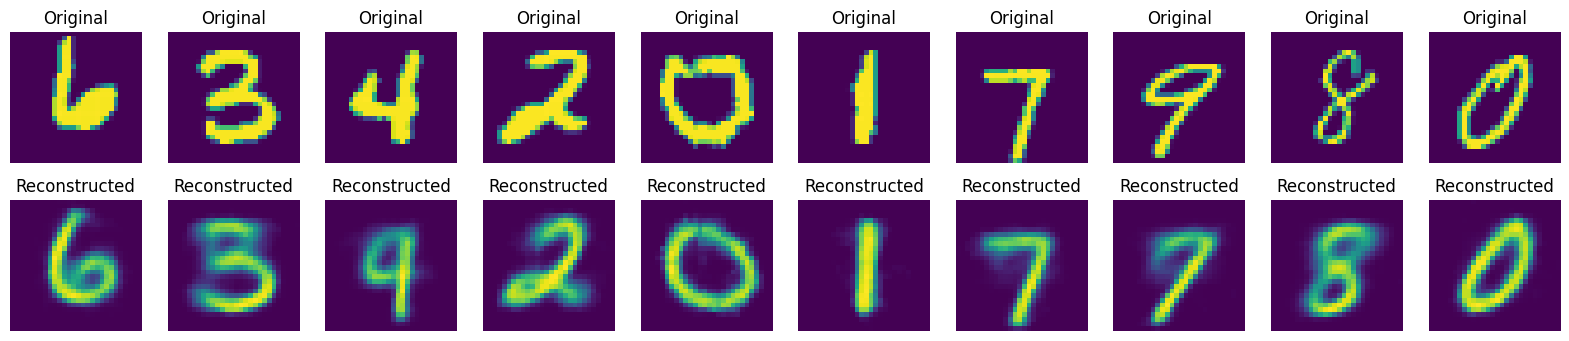

In [10]:
# Plot original and reconstructed images side by side
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original image: (C, H, W) -> (H, W, C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    # Display reconstructed image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()